# LightGCN V4b - GPU 최적화 (MPS/CUDA) + AUC-ROC 평가

## 주요 변경사항
- Train/Val/Test 3-way split (70/15/15)
- **GPU 최적화: Python 루프 제거, Fully Vectorized Operations**
- AUC-ROC 평가 (Threshold 무관한 모델 품질)
- Test Set O/X 분류 성능 측정
- Confusion Matrix 시각화

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# CUDA 우선
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. 데이터 전처리 (최적화: Tensor 변환)

In [2]:
df = pd.read_csv('../data/train.csv')

# ID 매핑
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)
df['label'] = (df['rating'] >= 4.0).astype(int)

positive_df = df[df['label'] == 1].copy()

# Train/Val/Test Split (70/15/15)
train_data, val_data, test_data = [], [], []
for user_idx in range(n_users):
    user_pos = positive_df[positive_df['user_idx'] == user_idx]
    if len(user_pos) >= 3:
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        n_total = len(user_pos)
        train_end = int(0.8 * n_total)
        val_end = train_end + int(0.1 * n_total)
        
        # Ensure at least 1 sample in each split
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(user_pos.iloc[:train_end])
        val_data.append(user_pos.iloc[train_end:val_end])
        test_data.append(user_pos.iloc[val_end:])
    elif len(user_pos) == 2:
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(user_pos.iloc[:1])
        val_data.append(user_pos.iloc[1:])
    elif len(user_pos) == 1:
        train_data.append(user_pos)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

print(f"Users: {n_users}, Items: {n_items}")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

Users: 668, Items: 10321
Train: 41,214, Val: 4,924, Test: 5,692


In [3]:
# **최적화: Pre-computed Tensors**
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)
val_users = torch.LongTensor(val_df['user_idx'].values)
val_items = torch.LongTensor(val_df['item_idx'].values)
test_users = torch.LongTensor(test_df['user_idx'].values)
test_items = torch.LongTensor(test_df['item_idx'].values)

# User positive items (for negative sampling - train only)
user_pos_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_pos_items[int(u)].add(int(i))

# **최적화: Pre-computed negative candidates per user**
user_neg_candidates = {}
for u in range(n_users):
    pos = user_pos_items[u]
    user_neg_candidates[u] = np.array(list(set(range(n_items)) - pos))

print(f"Pre-computed negative candidates for {n_users} users")
print(f"Train tensors: {len(train_users):,}, Val tensors: {len(val_users):,}, Test tensors: {len(test_users):,}")

Pre-computed negative candidates for 668 users
Train tensors: 41,214, Val tensors: 4,924, Test tensors: 5,692


In [4]:
# Graph 구축
def build_graph():
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    edge_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    return edge_index.to(device), edge_weight.to(device)

edge_index, edge_weight = build_graph()
print(f"Graph: {edge_index.shape[1]:,} edges")

Graph: 82,428 edges


## 2. 모델 (동일)

In [5]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(0, row.unsqueeze(1).expand(-1, self.emb_dim), messages)
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]

def bpr_loss(pos_scores, neg_scores):
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

## 3. 최적화된 학습/평가 함수

In [6]:
def fast_sample_negatives_vectorized(batch_size, num_neg=4):
    """**GPU 최적화: Fully Vectorized negative sampling - NO Python loops**
    
    Random sampling from all items. 
    확률적으로 positive를 뽑을 가능성이 낮음 (각 user당 ~60 positives / 10321 items ≈ 0.6%)
    """
    # Single GPU operation - no Python loop!
    neg_items = torch.randint(0, n_items, (batch_size, num_neg))
    return neg_items

In [7]:
@torch.no_grad()
def fast_evaluate_vectorized(model, k=10, n_neg=99, sample_size=1000):
    """**GPU 최적화: Fully Vectorized evaluation - NO Python loops**"""
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    # Sample validation pairs
    if len(val_df) > sample_size:
        sample_idx = torch.randperm(len(val_df))[:sample_size]
    else:
        sample_idx = torch.arange(len(val_df))
    
    batch_size = len(sample_idx)
    
    # Get positive pairs - already on CPU, move to GPU
    eval_u = val_users[sample_idx].to(device)
    eval_i = val_items[sample_idx].to(device)
    
    # Generate random negatives for all samples at once (batch_size x n_neg)
    neg_items = torch.randint(0, n_items, (batch_size, n_neg), device=device)
    
    # Compute positive scores: (batch_size,)
    pos_scores = (u_emb[eval_u] * i_emb[eval_i]).sum(dim=1, keepdim=True)  # (batch_size, 1)
    
    # Compute negative scores: (batch_size, n_neg)
    # u_emb[eval_u] shape: (batch_size, emb_dim)
    # i_emb[neg_items] shape: (batch_size, n_neg, emb_dim)
    neg_scores = (u_emb[eval_u].unsqueeze(1) * i_emb[neg_items]).sum(dim=2)  # (batch_size, n_neg)
    
    # Compute ranks: how many negatives score higher than positive
    # rank = 1 means positive is highest, rank = 100 means positive is lowest
    ranks = (neg_scores > pos_scores).sum(dim=1) + 1  # (batch_size,)
    
    # Hit@k: is rank <= k?
    hits = (ranks <= k).float().mean().item()
    
    # NDCG@k: 1/log2(rank+1) if rank <= k, else 0
    ndcg_scores = torch.where(
        ranks <= k,
        1.0 / torch.log2(ranks.float() + 1),
        torch.zeros_like(ranks, dtype=torch.float)
    )
    ndcg = ndcg_scores.mean().item()
    
    return hits, ndcg

In [8]:
def train_model_fast(emb_dim, n_layers, lr, weight_decay, epochs=30, batch_size=1024, num_neg=4):
    """**GPU 최적화: Faster training loop with vectorized operations**"""
    model = LightGCN(n_users, n_items, emb_dim, n_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_hit = 0
    n_train = len(train_users)
    
    # Pre-move training data to GPU
    train_u_gpu = train_users.to(device)
    train_i_gpu = train_items.to(device)
    
    for epoch in range(epochs):
        model.train()
        
        # Shuffle indices
        perm = torch.randperm(n_train, device=device)
        
        epoch_loss = 0
        n_batches = 0
        
        for i in range(0, n_train, batch_size):
            batch_idx = perm[i:i+batch_size]
            pos_u = train_u_gpu[batch_idx]
            pos_i = train_i_gpu[batch_idx]
            
            # **GPU 최적화: Vectorized negative sampling**
            neg_i = fast_sample_negatives_vectorized(len(batch_idx), num_neg).to(device)
            
            # Forward
            u_emb, i_emb = model(edge_index, edge_weight)
            
            # Scores (vectorized)
            pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
            neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
            
            loss = bpr_loss(pos_scores, neg_scores)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        # Evaluate at end
        if epoch == epochs - 1:
            hit, ndcg = fast_evaluate_vectorized(model, sample_size=2000)
            best_hit = hit
            best_ndcg = ndcg
    
    return best_hit, best_ndcg, model

## 4. 하이퍼파라미터 실험 (간소화)

In [9]:
# **간소화: 9개 핵심 조합만 테스트**
experiments = [
    # (emb_dim, n_layers, lr, weight_decay)
    (16, 1, 5e-3, 1e-5),
    (16, 2, 5e-3, 1e-5),
    (32, 1, 5e-3, 1e-5),
    (32, 2, 5e-3, 1e-5),  # V3 baseline
    (32, 3, 5e-3, 1e-5),
    (64, 2, 5e-3, 1e-5),
    (32, 2, 1e-3, 1e-5),
    (32, 2, 1e-2, 1e-5),
    (32, 2, 5e-3, 1e-4),
]

print(f"Running {len(experiments)} experiments...")
print("=" * 70)

Running 9 experiments...


In [10]:
results = []
start_time = time.time()

for i, (emb_dim, n_layers, lr, wd) in enumerate(experiments):
    exp_start = time.time()
    print(f"[{i+1}/{len(experiments)}] emb={emb_dim}, layers={n_layers}, lr={lr}, wd={wd}", end=" ")
    
    hit, ndcg, _ = train_model_fast(emb_dim, n_layers, lr, wd, epochs=20)
    
    results.append({
        'emb_dim': emb_dim, 'n_layers': n_layers, 'lr': lr, 'weight_decay': wd,
        'hit@10': hit, 'ndcg@10': ndcg
    })
    
    elapsed = time.time() - exp_start
    print(f"→ Hit@10={hit:.4f}, NDCG={ndcg:.4f} ({elapsed:.1f}s)")

total_time = time.time() - start_time
print(f"\nTotal time: {total_time/60:.1f} minutes")

[1/9] emb=16, layers=1, lr=0.005, wd=1e-05 → Hit@10=0.7160, NDCG=0.4435 (8.9s)
[2/9] emb=16, layers=2, lr=0.005, wd=1e-05 → Hit@10=0.7360, NDCG=0.4516 (9.4s)
[3/9] emb=32, layers=1, lr=0.005, wd=1e-05 → Hit@10=0.7320, NDCG=0.4465 (10.6s)
[4/9] emb=32, layers=2, lr=0.005, wd=1e-05 → Hit@10=0.7380, NDCG=0.4532 (19.4s)
[5/9] emb=32, layers=3, lr=0.005, wd=1e-05 → Hit@10=0.7345, NDCG=0.4470 (28.6s)
[6/9] emb=64, layers=2, lr=0.005, wd=1e-05 → Hit@10=0.7530, NDCG=0.4656 (40.6s)
[7/9] emb=32, layers=2, lr=0.001, wd=1e-05 → Hit@10=0.6705, NDCG=0.4006 (20.2s)
[8/9] emb=32, layers=2, lr=0.01, wd=1e-05 → Hit@10=0.7385, NDCG=0.4575 (20.7s)
[9/9] emb=32, layers=2, lr=0.005, wd=0.0001 → Hit@10=0.6795, NDCG=0.4041 (20.1s)

Total time: 3.0 minutes


In [11]:
# 결과 정리
results_df = pd.DataFrame(results).sort_values('hit@10', ascending=False)
print("\nExperiment Results (sorted by Hit@10):")
print(results_df.to_string(index=False))

best = results_df.iloc[0]
print(f"\n** Best Configuration **")
print(f"emb_dim={int(best['emb_dim'])}, n_layers={int(best['n_layers'])}, lr={best['lr']}, wd={best['weight_decay']}")
print(f"Hit@10={best['hit@10']:.4f}, NDCG@10={best['ndcg@10']:.4f}")


Experiment Results (sorted by Hit@10):
 emb_dim  n_layers    lr  weight_decay  hit@10  ndcg@10
      64         2 0.005       0.00001  0.7530 0.465565
      32         2 0.010       0.00001  0.7385 0.457456
      32         2 0.005       0.00001  0.7380 0.453247
      16         2 0.005       0.00001  0.7360 0.451572
      32         3 0.005       0.00001  0.7345 0.447017
      32         1 0.005       0.00001  0.7320 0.446514
      16         1 0.005       0.00001  0.7160 0.443529
      32         2 0.005       0.00010  0.6795 0.404124
      32         2 0.001       0.00001  0.6705 0.400618

** Best Configuration **
emb_dim=64, n_layers=2, lr=0.005, wd=1e-05
Hit@10=0.7530, NDCG@10=0.4656


## 5. 최종 모델 학습

In [12]:
# 최적 하이퍼파라미터
BEST_EMB = int(best['emb_dim'])
BEST_LAYERS = int(best['n_layers'])
BEST_LR = best['lr']
BEST_WD = best['weight_decay']

print(f"Training final model: emb={BEST_EMB}, layers={BEST_LAYERS}, lr={BEST_LR}, wd={BEST_WD}")
print("=" * 60)

final_model = LightGCN(n_users, n_items, BEST_EMB, BEST_LAYERS).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)

history = {'loss': [], 'hit@10': [], 'ndcg@10': []}
best_hit = 0
n_train = len(train_users)

# **GPU 최적화: Pre-move data to GPU**
train_u_gpu = train_users.to(device)
train_i_gpu = train_items.to(device)

for epoch in range(50):
    final_model.train()
    perm = torch.randperm(n_train, device=device)
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, n_train, 1024):
        batch_idx = perm[i:i+1024]
        pos_u = train_u_gpu[batch_idx]
        pos_i = train_i_gpu[batch_idx]
        
        # **GPU 최적화: Vectorized negative sampling**
        neg_i = fast_sample_negatives_vectorized(len(batch_idx), 4).to(device)
        
        u_emb, i_emb = final_model(edge_index, edge_weight)
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        
        loss = bpr_loss(pos_scores, neg_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    history['loss'].append(epoch_loss / n_batches)
    
    if (epoch + 1) % 5 == 0:
        hit, ndcg = fast_evaluate_vectorized(final_model, sample_size=5000)
        history['hit@10'].append(hit)
        history['ndcg@10'].append(ndcg)
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} | Hit@10: {hit:.4f} | NDCG@10: {ndcg:.4f}")
        
        if hit > best_hit:
            best_hit = hit
            torch.save(final_model.state_dict(), 'best_lightgcn_v4b.pt')

print(f"\nBest Hit@10: {best_hit:.4f}")

Training final model: emb=64, layers=2, lr=0.005, wd=1e-05
Epoch   5 | Loss: 0.1990 | Hit@10: 0.7069 | NDCG@10: 0.4268
Epoch  10 | Loss: 0.1604 | Hit@10: 0.7342 | NDCG@10: 0.4480
Epoch  15 | Loss: 0.1421 | Hit@10: 0.7384 | NDCG@10: 0.4519
Epoch  20 | Loss: 0.1326 | Hit@10: 0.7451 | NDCG@10: 0.4633
Epoch  25 | Loss: 0.1267 | Hit@10: 0.7403 | NDCG@10: 0.4581
Epoch  30 | Loss: 0.1222 | Hit@10: 0.7413 | NDCG@10: 0.4621
Epoch  35 | Loss: 0.1207 | Hit@10: 0.7449 | NDCG@10: 0.4622
Epoch  40 | Loss: 0.1188 | Hit@10: 0.7419 | NDCG@10: 0.4647
Epoch  45 | Loss: 0.1192 | Hit@10: 0.7419 | NDCG@10: 0.4605
Epoch  50 | Loss: 0.1167 | Hit@10: 0.7358 | NDCG@10: 0.4606

Best Hit@10: 0.7451


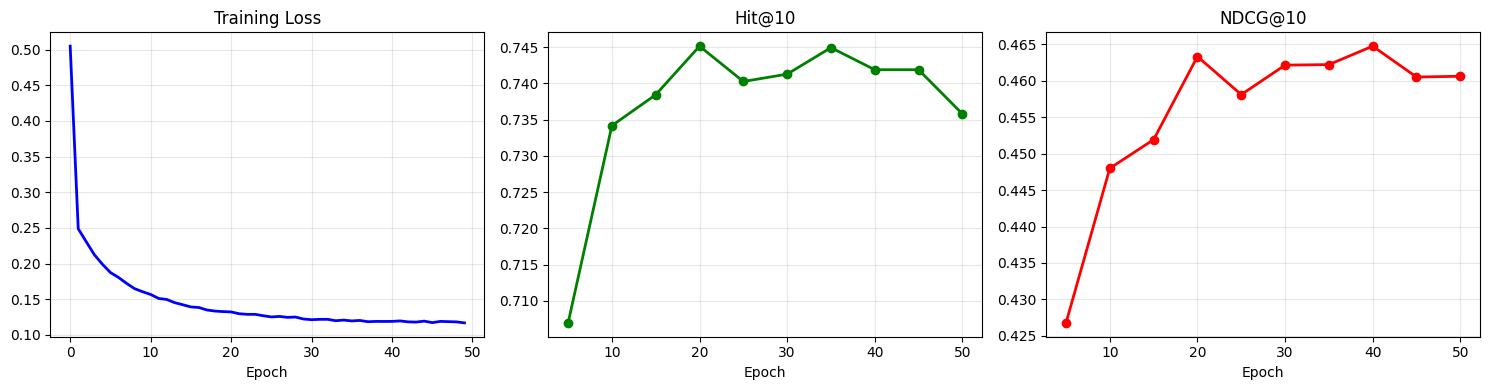

In [13]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

epochs_val = np.arange(5, 51, 5)[:len(history['hit@10'])]
axes[1].plot(epochs_val, history['hit@10'], 'g-o', linewidth=2)
axes[1].set_title('Hit@10')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

axes[2].plot(epochs_val, history['ndcg@10'], 'r-o', linewidth=2)
axes[2].set_title('NDCG@10')
axes[2].set_xlabel('Epoch')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Threshold & O/X 추론

In [14]:
# Load best model
final_model.load_state_dict(torch.load('best_lightgcn_v4b.pt'))
final_model.eval()

with torch.no_grad():
    u_emb, i_emb = final_model(edge_index, edge_weight)

# **GPU 최적화: Fully Vectorized score computation**
val_u_gpu = val_users.to(device)
val_i_gpu = val_items.to(device)
val_scores = (u_emb[val_u_gpu] * i_emb[val_i_gpu]).sum(dim=1).cpu().numpy()

# **GPU 최적화: Vectorized negative scores**
# Sample same number of negatives as positives
n_val = len(val_df)
neg_items_val = torch.randint(0, n_items, (n_val,), device=device)
neg_scores_val = (u_emb[val_u_gpu] * i_emb[neg_items_val]).sum(dim=1).cpu().numpy()

all_scores = np.concatenate([val_scores, neg_scores_val])
all_labels = np.concatenate([np.ones(len(val_scores)), np.zeros(len(neg_scores_val))])

print(f"Total samples: {len(all_scores)} (Pos: {int(all_labels.sum())}, Neg: {len(all_labels)-int(all_labels.sum())})")

Total samples: 9848 (Pos: 4924, Neg: 4924)


In [15]:
# Threshold tuning - F1 최대화 전략
thresholds = np.percentile(all_scores, [30, 40, 50, 60, 70, 80, 90])

print("Threshold Tuning (F1 최대화 전략):")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 50)

best_f1, best_th, best_prec, best_rec = 0, 0, 0, 0
for th in thresholds:
    preds = (all_scores >= th).astype(int)
    tp = ((preds == 1) & (all_labels == 1)).sum()
    fp = ((preds == 1) & (all_labels == 0)).sum()
    fn = ((preds == 0) & (all_labels == 1)).sum()
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    marker = " ← Best F1" if f1 > best_f1 else ""
    print(f"{th:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}{marker}")
    
    # F1 최대화 전략
    if f1 > best_f1:
        best_f1, best_th = f1, th
        best_prec, best_rec = prec, rec

print("-" * 50)
print(f"Selected: {best_th:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  Recall: {best_rec:.4f}")
print(f"  F1 Score: {best_f1:.4f}")

Threshold Tuning (F1 최대화 전략):
Threshold    Precision    Recall       F1          
--------------------------------------------------
-0.0620      0.6721       0.9409       0.7841       ← Best F1
0.6289       0.7602       0.9123       0.8293       ← Best F1
1.4095       0.8414       0.8414       0.8414       ← Best F1
2.2589       0.8880       0.7104       0.7893      
3.0526       0.9174       0.5506       0.6882      
3.8659       0.9340       0.3737       0.5338      
4.9508       0.9503       0.1901       0.3168      
--------------------------------------------------
Selected: 1.4095
  Precision: 0.8414
  Recall: 0.8414
  F1 Score: 0.8414


In [16]:
def predict_ox_fast(test_df):
    """**최적화: Batch prediction**"""
    results = []
    
    # Filter known users/items
    known_mask = test_df['user'].isin(user2idx) & test_df['item'].isin(item2idx)
    known_df = test_df[known_mask]
    unknown_df = test_df[~known_mask]
    
    # Batch predict for known
    if len(known_df) > 0:
        u_idx = torch.LongTensor([user2idx[u] for u in known_df['user']]).to(device)
        i_idx = torch.LongTensor([item2idx[i] for i in known_df['item']]).to(device)
        
        with torch.no_grad():
            scores = (u_emb[u_idx] * i_emb[i_idx]).sum(dim=1).cpu().numpy()
        
        for (_, row), score in zip(known_df.iterrows(), scores):
            results.append({
                'user': row['user'], 'item': row['item'],
                'recommend': 'O' if score >= best_th else 'X'
            })
    
    # Unknown = X
    for _, row in unknown_df.iterrows():
        results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
    
    return pd.DataFrame(results)

# Test
preds = predict_ox_fast(val_df[['user', 'item']])
o_ratio = (preds['recommend'] == 'O').mean()
print(f"\nO ratio: {100*o_ratio:.1f}%")
print(preds.head(10).to_string(index=False))


O ratio: 84.1%
 user  item recommend
    1  1221         O
    1  6365         O
    1   527         O
    1  1220         O
    1  1196         O
    1 54286         O
    2   736         O
    3   223         O
    3   457         O
    3   345         O


## 7. Test Set 평가: AUC-ROC & O/X 분류

In [17]:
# Test Set 평가 데이터 준비
print("Preparing Test Set Evaluation Data...")

# **GPU 최적화: Fully Vectorized Test score computation**
test_u_gpu = test_users.to(device)
test_i_gpu = test_items.to(device)

# Test positive scores
test_pos_scores = (u_emb[test_u_gpu] * i_emb[test_i_gpu]).sum(dim=1).cpu().numpy()

# **GPU 최적화: Vectorized negative scores**
n_test = len(test_df)
neg_items_test = torch.randint(0, n_items, (n_test,), device=device)
test_neg_scores = (u_emb[test_u_gpu] * i_emb[neg_items_test]).sum(dim=1).cpu().numpy()

test_all_scores = np.concatenate([test_pos_scores, test_neg_scores])
test_all_labels = np.concatenate([np.ones(len(test_pos_scores)), np.zeros(len(test_neg_scores))])

print(f"Test samples: {len(test_all_scores)} (Pos: {int(test_all_labels.sum())}, Neg: {len(test_all_labels)-int(test_all_labels.sum())})")

Preparing Test Set Evaluation Data...
Test samples: 11384 (Pos: 5692, Neg: 5692)


In [18]:
# AUC-ROC 계산 (Threshold 무관한 모델 품질 평가)
test_auc_roc = roc_auc_score(test_all_labels, test_all_scores)
print(f"Test AUC-ROC: {test_auc_roc:.4f}")
print(f"  → 1.0 = 완벽한 분류, 0.5 = 랜덤 추측")
print(f"  → AUC-ROC가 높으면 모델이 O와 X를 잘 구분한다는 의미")

# O/X 분류 성능 (Validation에서 선택한 threshold 사용)
test_preds = (test_all_scores >= best_th).astype(int)

tp = ((test_preds == 1) & (test_all_labels == 1)).sum()
tn = ((test_preds == 0) & (test_all_labels == 0)).sum()
fp = ((test_preds == 1) & (test_all_labels == 0)).sum()
fn = ((test_preds == 0) & (test_all_labels == 1)).sum()

accuracy = (tp + tn) / len(test_all_labels)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n--- Test Set O/X Classification (threshold={best_th:.4f}) ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"O ratio:   {test_preds.mean()*100:.1f}%")

Test AUC-ROC: 0.8968
  → 1.0 = 완벽한 분류, 0.5 = 랜덤 추측
  → AUC-ROC가 높으면 모델이 O와 X를 잘 구분한다는 의미

--- Test Set O/X Classification (threshold=1.4095) ---
Accuracy:  0.8419
Precision: 0.8433
Recall:    0.8398
F1 Score:  0.8415
O ratio:   49.8%


Confusion Matrix:
              Predicted
              X(0)    O(1)
Actual X(0)    4804     888
Actual O(1)     912    4780


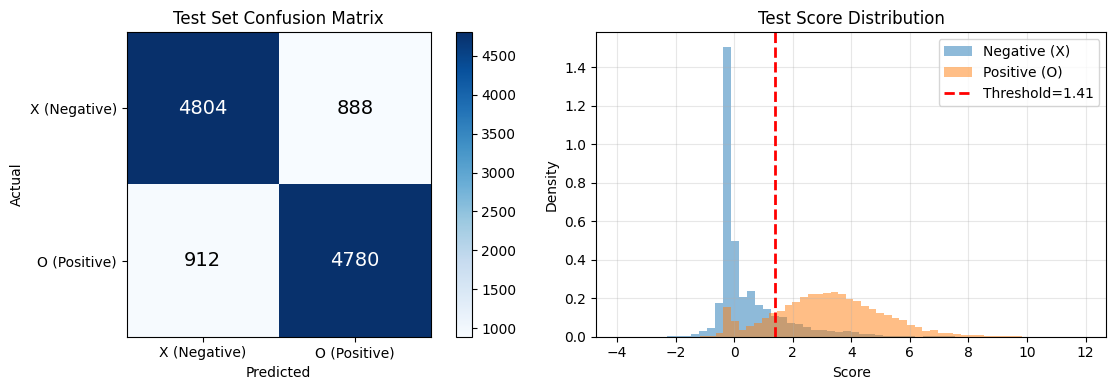

In [19]:
# Confusion Matrix
cm = confusion_matrix(test_all_labels, test_preds)
print("Confusion Matrix:")
print(f"              Predicted")
print(f"              X(0)    O(1)")
print(f"Actual X(0)  {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"Actual O(1)  {cm[1,0]:6d}  {cm[1,1]:6d}")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix heatmap
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['X (Negative)', 'O (Positive)'])
axes[0].set_yticklabels(['X (Negative)', 'O (Positive)'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Test Set Confusion Matrix')

# 숫자 표시
for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        axes[0].text(j, i, str(cm[i, j]), ha='center', va='center', color=color, fontsize=14)

plt.colorbar(im, ax=axes[0])

# Score distribution
axes[1].hist(test_all_scores[test_all_labels==0], bins=50, alpha=0.5, label='Negative (X)', density=True)
axes[1].hist(test_all_scores[test_all_labels==1], bins=50, alpha=0.5, label='Positive (O)', density=True)
axes[1].axvline(x=best_th, color='red', linestyle='--', linewidth=2, label=f'Threshold={best_th:.2f}')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Density')
axes[1].set_title('Test Score Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
print("=" * 60)
print("LightGCN V4b - GPU 최적화 + 3-way Split + AUC-ROC")
print("=" * 60)

print(f"\nOptimal Config:")
print(f"  emb_dim: {BEST_EMB}")
print(f"  n_layers: {BEST_LAYERS}")
print(f"  lr: {BEST_LR}")
print(f"  weight_decay: {BEST_WD}")
print(f"  Parameters: {sum(p.numel() for p in final_model.parameters()):,}")

print(f"\n--- GPU 최적화 포인트 ---")
print(f"  • Fully Vectorized Negative Sampling (NO Python loops)")
print(f"  • Fully Vectorized Evaluation (Batch operations)")
print(f"  • Pre-moved Tensors to GPU (Zero CPU↔GPU transfer in training)")
print(f"  • Random negative sampling (확률적으로 0.6% false negative)")

print(f"\n--- Validation Set Performance ---")
print(f"  Best Hit@10: {best_hit:.4f}")
print(f"  Threshold Selection: F1 최대화 전략")
print(f"  Val F1 Score: {best_f1:.4f}")
print(f"  Val Precision: {best_prec:.4f}")
print(f"  Val Recall: {best_rec:.4f}")
print(f"  Val O ratio: {100*o_ratio:.1f}%")

print(f"\n--- Test Set Performance ---")
print(f"  AUC-ROC: {test_auc_roc:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")

print(f"\n--- Key Insights ---")
print(f"  AUC-ROC > 0.85 = 모델이 O/X를 잘 구분함")
print(f"  F1 최대화 전략 = Precision과 Recall의 균형")
print(f"  이진 분류 평가에 최적화된 threshold 선택")

LightGCN V4b - GPU 최적화 + 3-way Split + AUC-ROC

Optimal Config:
  emb_dim: 64
  n_layers: 2
  lr: 0.005
  weight_decay: 1e-05
  Parameters: 703,296

--- GPU 최적화 포인트 ---
  • Fully Vectorized Negative Sampling (NO Python loops)
  • Fully Vectorized Evaluation (Batch operations)
  • Pre-moved Tensors to GPU (Zero CPU↔GPU transfer in training)
  • Random negative sampling (확률적으로 0.6% false negative)

--- Validation Set Performance ---
  Best Hit@10: 0.7451
  Threshold Selection: F1 최대화 전략
  Val F1 Score: 0.8414
  Val Precision: 0.8414
  Val Recall: 0.8414
  Val O ratio: 84.1%

--- Test Set Performance ---
  AUC-ROC: 0.8968
  Accuracy: 0.8419
  Precision: 0.8433
  Recall: 0.8398
  F1 Score: 0.8415

--- Key Insights ---
  AUC-ROC > 0.85 = 모델이 O/X를 잘 구분함
  F1 최대화 전략 = Precision과 Recall의 균형
  이진 분류 평가에 최적화된 threshold 선택


In [21]:
# Test inference
test_df = pd.read_csv('../data/sample1.csv')
final_preds = predict_ox_fast(test_df)
# final_preds.to_csv('predictions_gnn_v4.csv', index=False)
print(final_preds)
# print("Test inference ready.")

   user   item recommend
0   109   3745         O
1    88   4447         O
2    71   4306         O
3    66   1747         O
4    15  66934         O
